In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy
from scipy.interpolate import interp1d

from numpy.fft import fftshift, fft2, ifft2, fft, ifft
from numpy import real
from numpy import conj

import tiff_file

%matplotlib notebook


tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


Set the directory for where the data is below.

In [25]:
data_dir = "Z:\\Michelle_research\\Data\\2019-06-19_shearing\\22_3_cooling\\"
data_file = "22_3_cooling.tif"

#The pixel size for the shearing stage is 0.497 microns. 
pixel_size = 0.497

In [26]:
images = tiff_file.imread(data_dir + data_file)
print "Number of frames in %s: %s" % (data_file, images.shape[0])

Number of frames in 22_3_cooling.tif: 157


Below we define the function for 2D image autocorrelation

In [5]:
def autocorrelation_2D(image):
    data = image-image.mean() 
    data = data / data.std()
    
    temp = real(fftshift(ifft2(fft2(data)*conj(fft2(data)))))
    temp = temp / (data.shape[0]*data.shape[1])
    
    return temp

In [6]:
def autocorrelation_1D(image, ax):
    # This function computes a 1D correlation
    # of a 2D image. 
    # Input parameters:
    #    image -- a 2D numpy array
    #    ax -- the axis to perform the autocorrelation
    #
    # Note about which axes to use:
    #   for ax = 0: this will correlate things along the vertical direction when displayed using matshow
    #   for ax = 1: this will correlate along the horizontal direction when displayed using matshow
    
    means = image.mean(axis=ax)
    temp = np.tile(means, (image.shape[ax], 1))
    if ax==0:
        data = image - temp
    elif ax==1:
        data = image - temp.transpose()
    else:
        print "ax must be 0 or 1"
        return 0
    
    std_devs = data.std(axis=ax)
    #print "shape of std_devs: ", std_devs.shape #for debugging purposes
    temp = np.tile(std_devs, (image.shape[ax],1))
    if ax==0:
        data = data / temp
    elif ax==1:
        data = data / temp.transpose()
        
    temp = fftshift(ifft(fft(data,axis=ax)*conj(fft(data,axis=ax)),axis=ax),axes=ax)
    temp = real(temp) / data.shape[ax]
       
    if ax==0:
        corr = temp.sum(axis=1)/temp.shape[1]
        return corr[temp.shape[0]/2:]
    elif ax==1:
        corr = temp.sum(axis=0)/temp.shape[0]
        return corr[temp.shape[1]/2:]

In [7]:
def find_where_corr_at_half(corr, val=0.5):
    # This function will actually only find where the correlation function goes to 0.5
    # (which, if properly normalized, means that it dropped 50%) if the "val" is set
    # to 0.5 which is the default. However, you can change that to another value like
    # 0.2 or 1/e or something else. 
    f = interp1d(np.arange(0,len(corr)), corr, kind='linear', fill_value="extrapolate") #create interpolation function
    new_x = np.linspace(0, len(corr), 10*len(corr))  #new x-axis that is 10 times more sampled
    eval_at_new_x = f(new_x) #evaluate the interpolated function over the new range of x-values
    min_index = np.argmin(abs(eval_at_new_x-val)) #find where that is closest to "val" 
    return new_x[min_index]

<IPython.core.display.Javascript object>


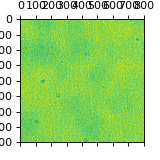

<IPython.core.display.Javascript object>


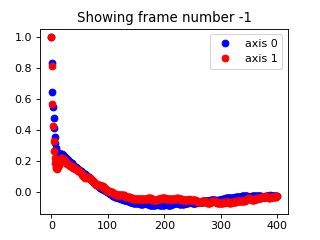

Where the correlation goes to 50% for axis 0:  3.700925231307827
Where the correlation goes to 50% for axis 1:  2.5006251562890722


In [27]:
%matplotlib notebook
frame_to_show = -1
im = images[frame_to_show]
plt.figure(figsize=(2,2))
plt.matshow(im, fignum=0)
corr2d = autocorrelation_2D(im)
plt.figure(figsize=(4,3))
acorr_0 = autocorrelation_1D(im,0)
acorr_1 = autocorrelation_1D(im,1)
plt.plot(acorr_0,'bo',label='axis 0')
plt.plot(acorr_1,'ro',label='axis 1')
#plt.plot(corr2d[im.shape[0]/2,im.shape[1]/2:], 'go')
#plt.plot(corr2d[im.shape[0]/2:,im.shape[1]/2], 'mo')
print "Where the correlation goes to 50% for axis 0: ", find_where_corr_at_half(acorr_0)
print "Where the correlation goes to 50% for axis 1: ", find_where_corr_at_half(acorr_1)
plt.title("Showing frame number %i" % frame_to_show)
plt.legend(loc=0)

Below, we will loop over all frames in the movie and find where the autocorrelation along x and along y reaches 0.5 (50% of the maximum).

In [28]:
xCorr50 = np.zeros(images.shape[0])
yCorr50 = np.zeros_like(xCorr50)
allXc = np.zeros((images.shape[0], images.shape[1]/2))
allYc = np.zeros((images.shape[0], images.shape[2]/2))
for i in range(images.shape[0]):
    xc = autocorrelation_1D(images[i], 0)
    yc = autocorrelation_1D(images[i], 1)
    xCorr50[i] = find_where_corr_at_half(xc, val=0.1)
    yCorr50[i] = find_where_corr_at_half(yc, val=0.1)
    allXc[i] = xc
    allYc[i] = yc

<IPython.core.display.Javascript object>


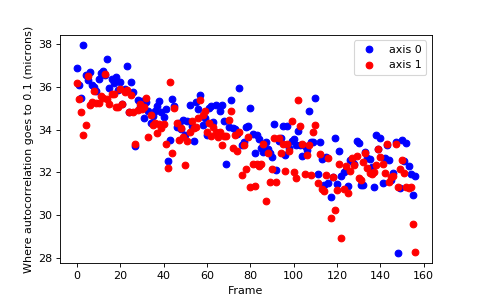

In [29]:
fig = plt.figure(figsize=(6,6/1.618))
plt.plot(xCorr50 * pixel_size, 'bo', label="axis 0")
plt.plot(yCorr50 * pixel_size, 'ro', label="axis 1")
plt.xlabel("Frame")
plt.ylabel("Where autocorrelation goes to 0.1 (microns)")
plt.legend(loc=0)

<IPython.core.display.Javascript object>


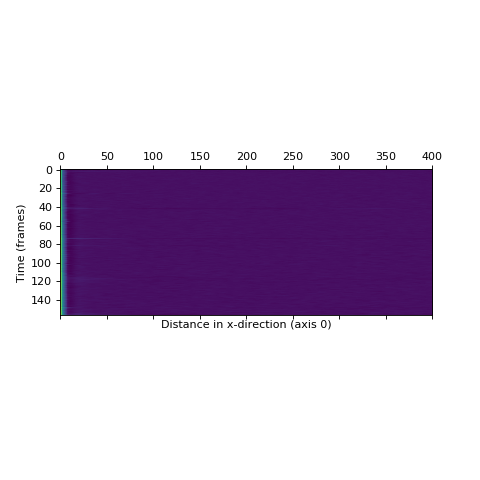

<IPython.core.display.Javascript object>


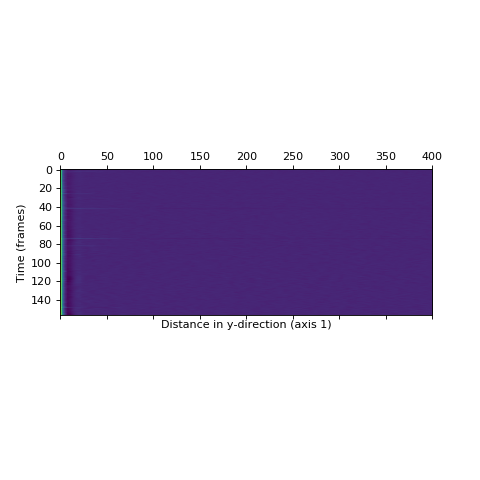

Text(0,0.5,'Time (frames)')

In [21]:
fig = plt.figure(figsize=(6,6))
plt.matshow(allXc[:,:],fignum=0)
plt.xlabel("Distance in x-direction (axis 0)")
plt.ylabel("Time (frames)")

fig = plt.figure(figsize=(6,6))
plt.matshow(allYc[:,:],fignum=0)
plt.xlabel("Distance in y-direction (axis 1)")
plt.ylabel("Time (frames)")

In [15]:
data_results = {} #Initializes a new dictionary
data_results['xCorr_50'] = xCorr50 * pixel_size
data_results['yCorr_50'] = yCorr50 * pixel_size
data_results['data_location'] = data_dir
data_results['data_file'] = data_file
data_results['xcorrelations_alltimes'] = allXc
data_results['ycorrelations_alltimes'] = allYc

#################################################################
# Next use the pickle.dump function to save this 'data_results' #
# dictionary to file. See the example analysis notebook.        #
#################################################################